In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import sklearn as skl

In [4]:
spark = SparkSession.builder.appName('SparkSQL').getOrCreate()

In [5]:
spark.sparkContext.addFile('games_metadata_profile_2024_01.csv')
df = spark.read.csv(SparkFiles.get('games_metadata_profile_2024_01.csv'), header=True, inferSchema= True)

In [6]:
df.createOrReplaceTempView('chess')

In [398]:
df.show()

+------+-----------------+-----+--------------------+----------+-------------------+---------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+--------+---------------+----------------+------------------+------------------+-----------------+--------------------+---------------+-----------+--------------------+----------+---+--------------------+-----------+------------+-------+
|GameID|            Event|Round|                Site|      Date|               Time|          White|WhiteElo|WhiteRatingDiff|White_is_deleted|White_tosViolation|White_profile_flag|  White_createdAt|White_playTime_total|White_count_all|White_title|               Black|BlackElo|BlackRatingDiff|Black_is_deleted|Black_tosViolation|Black_profile_flag|  Black_createdAt|Black_playTime_total|Black_count_all|Black_title|               Moves|TotalMoves|ECO|             Opening|TimeControl| Terminati

In [11]:
data = spark.sql(
    '''
SELECT WhiteElo, White_playTime_total, White_count_all, BlackElo, Black_playTime_total, Black_count_all, TotalMoves,
Result from chess
WHERE Result != '*'
'''
).toPandas()

In [12]:
data.dropna(inplace=True)

In [13]:
data['Rating Difference'] = data['WhiteElo'] - data['BlackElo']
data['Playtime Difference'] = data['White_playTime_total'] - data['Black_playTime_total']
data['Games Played Difference'] = data['White_count_all'] - data['Black_count_all']
data['White Average Playtime'] = data['White_playTime_total']/data['White_count_all']
data['Black Average Playtime'] = data['Black_playTime_total']/data['Black_count_all']
data['Average Playtime Difference'] = data['White Average Playtime'] - data['Black Average Playtime']

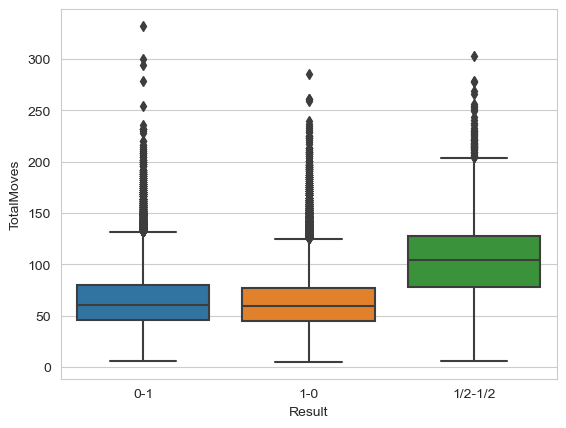

In [19]:
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['TotalMoves'])

(-10000000.0, 10000000.0)

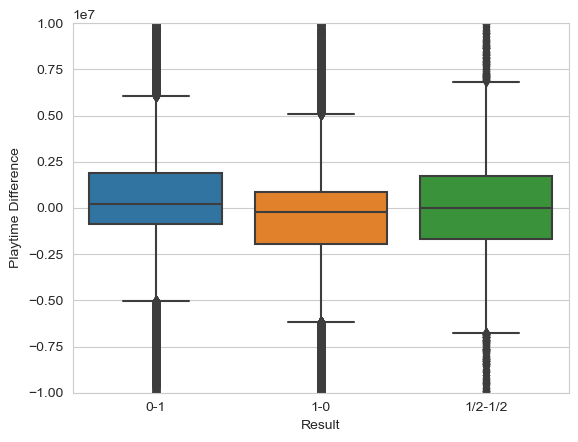

In [14]:
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Playtime Difference'])
ax.set_ylim(bottom = -10000000, top = 10000000)

(-30000.0, 30000.0)

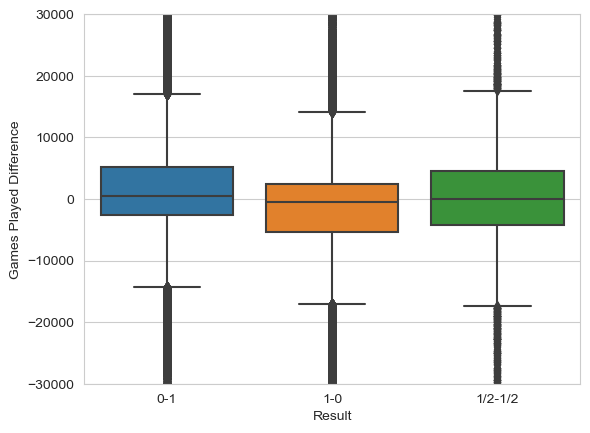

In [15]:
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Games Played Difference'])
ax.set_ylim(bottom = -30000, top = 30000)

(-200.0, 200.0)

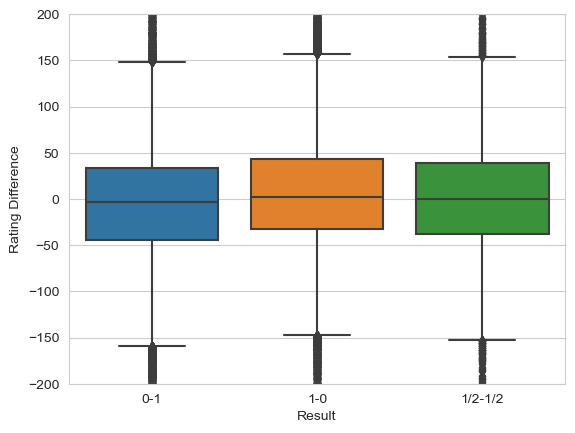

In [16]:
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Rating Difference'])
ax.set_ylim(bottom = -200, top = 200)

(-600.0, 600.0)

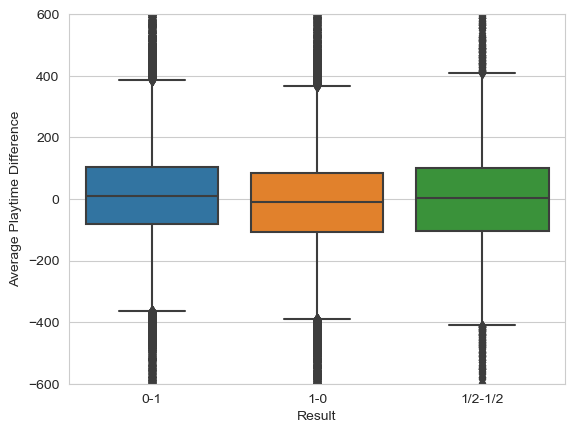

In [17]:
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=data['Result'], y=data['Average Playtime Difference'])
ax.set_ylim(bottom = -600, top = 600)

In [30]:
data.drop(['WhiteElo','BlackElo','White_count_all','Black_count_all','White_playTime_total','Black_playTime_total'],axis=1,inplace=True)

In [31]:
y = pd.get_dummies(data['Result'])
X = pd.get_dummies(data.drop('Result', axis=1))

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [33]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=512, random_state=78)

In [27]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [28]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [29]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.1169541760842616, 'TotalMoves'),
 (0.08187917573691235, 'Rating Difference'),
 (0.07641592104603849, 'Playtime Difference'),
 (0.07433613460719238, 'Black_playTime_total'),
 (0.07402620666211773, 'White_playTime_total'),
 (0.0739473714589364, 'Games Played Difference'),
 (0.07389233410717794, 'Average Playtime Difference'),
 (0.07241211819416553, 'Black_count_all'),
 (0.07147684022511464, 'White_count_all'),
 (0.07134125737622324, 'BlackElo'),
 (0.0712278364654999, 'WhiteElo'),
 (0.0711461691701501, 'Black Average Playtime'),
 (0.07094445886620966, 'White Average Playtime')]

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [329]:
from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [23]:
# Define the model - deep neural net
number_input_features = len(X_train.columns)

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=256, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

nn.add(tf.keras.layers.Dense(units=64, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=3, activation="softmax"))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
Total params: 28547 (111.51 KB)
Trainable params: 28547 (111.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
nn.compile(loss="CategoricalCrossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100


2946/2946 [==============================] - 3s 775us/step - loss: 0.7831 - accuracy: 0.5560
Epoch 2/100
2946/2946 [==============================] - 2s 761us/step - loss: 0.7707 - accuracy: 0.5691
Epoch 3/100
2946/2946 [==============================] - 2s 758us/step - loss: 0.7674 - accuracy: 0.5745
Epoch 4/100
2946/2946 [==============================] - 2s 774us/step - loss: 0.7649 - accuracy: 0.5765
Epoch 5/100
2946/2946 [==============================] - 2s 770us/step - loss: 0.7623 - accuracy: 0.5799
Epoch 6/100
2946/2946 [==============================] - 2s 750us/step - loss: 0.7604 - accuracy: 0.5807
Epoch 7/100
2946/2946 [==============================] - 2s 754us/step - loss: 0.7592 - accuracy: 0.5827
Epoch 8/100
2946/2946 [==============================] - 2s 770us/step - loss: 0.7576 - accuracy: 0.5853
Epoch 9/100
2946/2946 [==============================] - 2s 747us/step - loss: 0.7564 - accuracy: 0.5851
Epoch 10/100
2946/2946 [=============================

KeyboardInterrupt: 

In [264]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid','softmax','swish'])
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=512,
        step=5), activation=activation, input_dim=len(X_train.columns)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 8)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=512,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation='softmax'))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [269]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

In [266]:
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 1 Complete [00h 00m 16s]
val_accuracy: 0.5041532516479492

Best val_accuracy So Far: 0.5041532516479492
Total elapsed time: 00h 00m 16s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
relu              |softmax           |activation
361               |471               |first_units
4                 |6                 |num_layers
411               |46                |units_0
221               |1                 |units_1
251               |1                 |units_2
216               |1                 |units_3
266               |1                 |units_4
271               |1                 |units_5
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
2946/2946 [==============================] - 6s 2ms/step - loss: 0.6784 - accuracy: 0.4990 - val_loss: 0.6702 - val_accuracy: 0.5042

KeyboardInterrupt: 